In [1]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import LinearSVC

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Выводим корреляционную матрицу
def show_correlation_map(df):
    cor = df.corr()
    plt.figure(figsize=(16,9))
    sns.heatmap(cor, center=0, cmap="winter", annot = True)
    plt.show()

Загрузим датасет, преборазуем признаки имеющие два значения в индикаторные, а категориальные закодируем One Hot Encoding.

In [2]:
data = pd.read_csv('./heart.csv', delimiter=(','))

labelEncoder = LabelEncoder()
labelEncoder.fit(data['Sex'])
data['Sex'] = pd.Series(data = labelEncoder.transform(data['Sex']))

labelEncoder = LabelEncoder()
labelEncoder.fit(data['ExerciseAngina'])
data['ExerciseAngina'] = pd.Series(data = labelEncoder.transform(data['ExerciseAngina']))

data=pd.get_dummies(data)

Выведем корреляционную матрицу, изучим зависимости датасета.

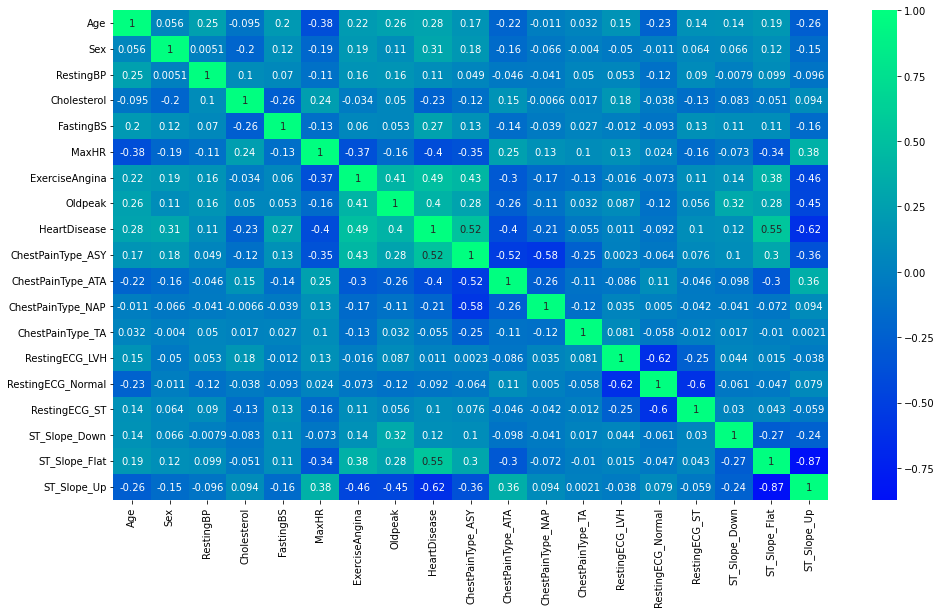

In [3]:
show_correlation_map(data)

Построим график риска сердечной недостаточности к возрасту.

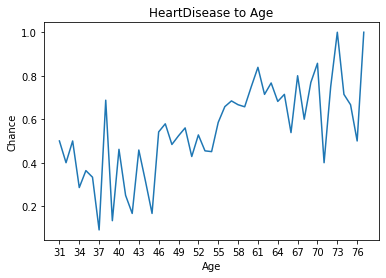

In [4]:
ages = data.loc[:, ['Age', 'HeartDisease']]
al = ages.loc[:, ['Age']]
al = al.value_counts()
dis = ages[ages['HeartDisease']==1]
dis.drop('HeartDisease', inplace=True, axis=1)
dis = dis.value_counts()
chances = {}
for key in sorted(dis.keys()):
    chances[key[0]] = dis[key]/al[key]
fig = plt.figure()
ax = fig.add_subplot(xlabel="Age", ylabel="Chance")
plt.title('HeartDisease to Age')
plt.xticks(np.arange(min(chances.keys()), max(chances.keys())+1, 3.0))
plt.plot(chances.keys(), chances.values())
plt.show()

Разобьем выборку на обучающую и тестовую.
Обучим модели дерева решений и случайный лес.
Выведем метрики.

In [5]:
X = data.loc[:, data.columns != 'HeartDisease']
Y = data['HeartDisease']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train,Y_train)
predictions_dtc = dtc.predict(X_test)

rfc=RandomForestClassifier(n_estimators=100)
rfc.fit(X_train,Y_train)
predictions_rfc = rfc.predict(X_test)

print('DecisionTreeClassifier metrics:\n', classification_report(Y_test, predictions_dtc))
print('RandomForestClassifier metrics:\n', classification_report(Y_test, predictions_rfc))

DecisionTreeClassifier metrics:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81        87
           1       0.84      0.78      0.81        97

    accuracy                           0.81       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.81      0.81      0.81       184

RandomForestClassifier metrics:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87        87
           1       0.88      0.89      0.88        97

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



Выведем наиболее важные параметры в случайном лесу.

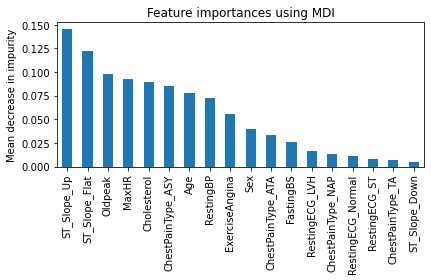

In [6]:
imp = pd.Series(rfc.feature_importances_)
imp.index = pd.Series(X_train.columns)
imp.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots()
imp.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Обучим Бэгинг модели дерева решений, выведем метрики.

In [7]:
bagging = BaggingClassifier(DecisionTreeClassifier(), max_samples=0.5, max_features=0.5)
bagging.fit(X_train, Y_train)
predictions_bag = bagging.predict(X_test)
print('BaggingClassifier metrics:\n', classification_report(Y_test, predictions_bag))

BaggingClassifier metrics:
               precision    recall  f1-score   support

           0       0.86      0.83      0.84        87
           1       0.85      0.88      0.86        97

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



Обучим стэкинг на трех моделях, выведем метрики.

In [8]:
stack_model = StackingClassifier(
    [
        ('LinearSVC', LinearSVC()),
        ('DecisionTreeClassifier', DecisionTreeClassifier()),
        ('RandomForestClassifier', RandomForestClassifier())
    ])
stack_model.fit(X_train, Y_train)
predictions_stack = stack_model.predict(X_test)
print('StackingClassifier metrics:\n', classification_report(Y_test, predictions_stack))

StackingClassifier metrics:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87        87
           1       0.90      0.85      0.87        97

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



Методы стэкинга, бэгинга и случайного леса показывают примерно одинаковые результаты. 
Однако, метод стэкинга имеет лучшие показатели precision и recall на несколько сотых и площадь AUC будет незначительно больше.
Случайный лес имеет встроенный показатель важности параметров, что тоже является плюсом при промежуточном анализе данных и выборе модели.